*First compiled: July 20, 2017.*

# Monocle 2 for data of [Paul *et al.*, Cell (2015)](https://doi.org/10.1016/j.cell.2015.11.013): original preprocessing

This notebook is a commented, partly shortened and partly extended version of the notebook that accompanies the Monocle 2 publication of [Qiu *et al.*, Nat. Meth. (2017)](https://doi.org/10.1038/nmeth.4402), available from 
[here](https://github.com/cole-trapnell-lab/monocle2-rge-paper/blob/26ce18c97f22e9488eb85971a23311f5252bfce5/Paul_dataset_analysis_final.ipynb).

It uses the same data as accessible within Scanpy via [*sc.examples.paul15()*](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.datasets.paul15.html).

In [1]:
rm(list = ls()) # clear the environment 
options(warn=-1) # turn off warning message globally 
suppressMessages(library(monocle))
suppressMessages(library(plyr))
suppressMessages(library(dplyr))

# Load the data

This RData is from Maren Büttner in the Theis lab https://github.com/theislab/scAnalysisTutorial. It's the same data as the one available within Scanpy [*sc.examples.paul15()*](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.datasets.paul15.html).

In [2]:
load('./data/Paul_Cell_MARSseq_GSE72857.RData') 
# the following code is used to select feature genes used by Maren 
gene.names <-sapply(strsplit(rownames(data.debatched), ";"), "[", 1)
is.informative <- gene.names %in% info.genes[order(info.genes)]
data.info.genes <- data.debatched[is.informative,]
rownames(data.info.genes) <- gene.names[is.informative]

# Create the cell datasets

How the following files were obtained by [Qiu *et al.*, Nat. Meth. (2017)](https://doi.org/10.1038/nmeth.4402). Within this repo, we provide the file [*MAP.csv*](data/MAP.csv) that has been sent out by email.
1. we downloaded the GSE72857_umitab.txt.gz / GSE72857_experimental_design.txt.gz file from GEO website
2. we obtained MAP.csv from Ido Amit group through email
3. we intersect the gene names from the GSE72857_umitab file and those from the info.genes created by Maren Büttner to define the informative genes.
4. we used the expression matrix from her to create the cds (Steps 3 & 4 are used for the purpose of consistency with DPT)

In [3]:
previous_time <- proc.time()[3]
################################################################################################################################################
# obtain this mat file from Ido Amit group  
MAP_cells_clusters <- read.csv('./data/MAP.csv', header = F)
row.names(MAP_cells_clusters) <- MAP_cells_clusters$V1

#filtering cells to include only the ones which were assigned a cluster id: 
valid_subset_GSE72857_exprs <- read.table('./data/GSE72857_umitab.txt', header = T, row.names = 1)
design_mat <- read.table('./data/GSE72857_experimental_design.txt', header = T, row.names = 1, skip = 19, sep = '\t')
design_mat$cluster <- MAP_cells_clusters[row.names(design_mat), 'V2']
valid_design_mat <- subset(design_mat, !is.na(cluster))

# Get the intersect gene used by Maren Büttner and the genes we have 
common_genes <- rownames(valid_subset_GSE72857_exprs)[rownames(valid_subset_GSE72857_exprs) %in% info.genes]
fd <- new("AnnotatedDataFrame", data = data.frame(gene_short_name = common_genes, row.names = common_genes))
pd <- new("AnnotatedDataFrame", data = valid_design_mat)

# create a CDS with data.info.genes 
valid_subset_GSE72857_cds <- newCellDataSet(as(as.matrix(data.info.genes[common_genes, ]), 'sparseMatrix'), 
                                            phenoData = pd, 
                                            featureData = fd,
                                            lowerDetectionLimit=1,
                                            expressionFamily=negbinomial.size())
valid_subset_GSE72857_cds <- estimateSizeFactors(valid_subset_GSE72857_cds)
valid_subset_GSE72857_cds <- estimateDispersions(valid_subset_GSE72857_cds)

pData(valid_subset_GSE72857_cds)$cell_type <- revalue(as.character(pData(valid_subset_GSE72857_cds)$cluster), 
                                                      c("1" = 'erythroid', "2" = 'erythroid', "3" = 'erythroid', "4" = 'erythroid', "5" = 'erythroid', "6" = 'erythroid', 
                                                        "7" = 'CMP', "8" = 'CMP', "9" = 'CMP', "10" = 'CMP',
                                                        "11" = 'DC', 
                                                        "12" = 'GMP', "13" = 'GMP', "14" = 'GMP', "15" = 'GMP', "16" = 'GMP', "17" = 'GMP', "18" = 'GMP', 
                                                        "19" = 'lymphoid'))

# remove all lymphoid cells as they do not belong to myeloid lineage 
valid_subset_GSE72857_cds <- valid_subset_GSE72857_cds[, pData(valid_subset_GSE72857_cds)$cell_type != 'lymphoid']
proc.time()[3] - previous_time

Removing 23 outliers


elapsed 
142.396

# Reconstructing the trajectory with Monocle 2 

The variance explained by each component in PCA.

Warning message in (function (A, nv = 5, nu = nv, maxit = 100, work = nv + 7, reorth = TRUE, :
“did not converge--results might be invlaid!; try increasing maxit or fastpath=FALSE”

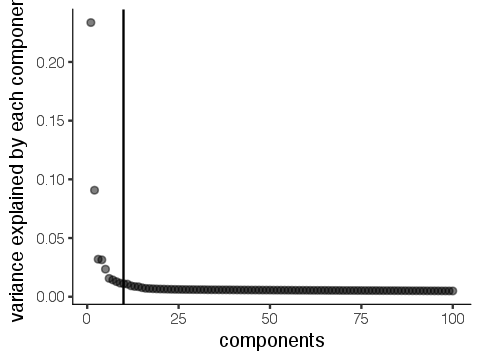

In [4]:
options(repr.plot.width=4, repr.plot.height=3)
plot_pc_variance_explained(valid_subset_GSE72857_cds) + geom_vline(xintercept = 10)

The actual computation.

In [5]:
previous_time <- proc.time()[3]
valid_subset_GSE72857_cds2 <- reduceDimension(valid_subset_GSE72857_cds,
                                              norm_method = 'log', verbose = F, max_components = 10) 
valid_subset_GSE72857_cds2 <- orderCells(valid_subset_GSE72857_cds2, reverse = T)
proc.time()[3] - previous_time

elapsed 
195.685

# Reproducing Supplemental Figure 16 of [Qiu *et al.*, Nat. Meth. (2017)](https://doi.org/10.1038/nmeth.4402)

## Supplemental Figure 16a

The figure differs slightly from the figure in the paper and the accompanying [notebook](https://github.com/cole-trapnell-lab/monocle2-rge-paper/blob/26ce18c97f22e9488eb85971a23311f5252bfce5/Paul_dataset_analysis_final.ipynb); according Xiaojie Qiu, this is due to a random number generator in a dependency of Monocle 2. The qualitative result is the same, though.

The following `from` values were not present in `x`: 19


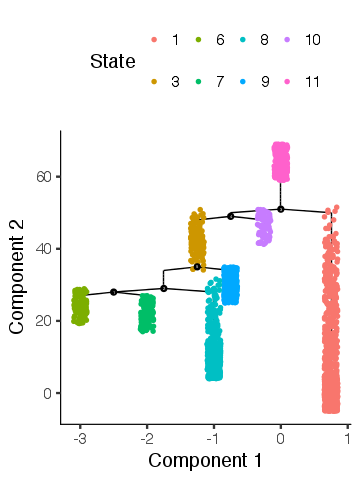

In [8]:
detailed_cell_type_color <- c("B" = "#E088B8", "DC" = "#46C7EF", "Eos" = "#EFAD1E", "Ery" = "#8CB3DF", "Mo" = "#53C0AD", "MEP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "Neu" = "#F5918A", "lymphoid" = "#FF0000")

pData(valid_subset_GSE72857_cds2)$cell_type2 <- revalue(as.character(pData(valid_subset_GSE72857_cds2)$cluster), 
                                                        c("1" = 'Ery', "2" = 'Ery', "3" = 'Ery', "4" = 'Ery', "5" = 'Ery', "6" = 'Ery', 
                                                          "7" = 'MEP', "8" = 'MK', "9" = 'GMP', "10" = 'GMP',
                                                          "11" = 'DC', 
                                                          "12" = 'B', "13" = 'B', "14" = 'Mo', "15" = 'Mo', "16" = 'Neu', "17" = 'Neu', "18" = 'Eos', 
                                                          "19" = 'lymphoid'))

options(repr.plot.width=3, repr.plot.height=4)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'State', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(11))

## Supplemental Figure 16b

The figure differs slightly from the figure in the paper and the accompanying [notebook](https://github.com/cole-trapnell-lab/monocle2-rge-paper/blob/26ce18c97f22e9488eb85971a23311f5252bfce5/Paul_dataset_analysis_final.ipynb); according Xiaojie Qiu, this is due to a random number generator in a dependency of Monocle 2. The qualitative result is the same, though.

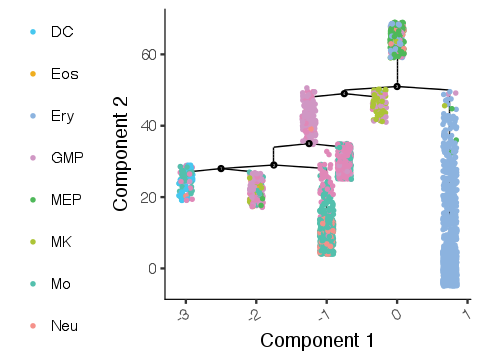

In [9]:
options(repr.plot.width=4, repr.plot.height=3)
plot_complex_cell_trajectory(valid_subset_GSE72857_cds2, color_by = 'as.factor(cell_type2)', show_branch_points = T, 
                             cell_size = 0.5, cell_link_size = 0.3, root_states = c(11)) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
  theme (legend.position="left", legend.title=element_blank()) + scale_color_manual(values = detailed_cell_type_color)

## Supplemental Figure 16c

The figure differs slightly from the figure in the paper and the accompanying [notebook](https://github.com/cole-trapnell-lab/monocle2-rge-paper/blob/26ce18c97f22e9488eb85971a23311f5252bfce5/Paul_dataset_analysis_final.ipynb); according Xiaojie Qiu, this is due to a random number generator in a dependency of Monocle 2. The qualitative result is the same, though.

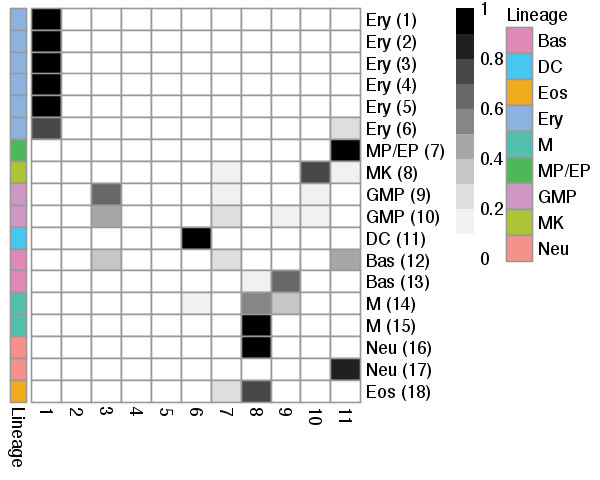

In [7]:
annotation_row = data.frame(`Lineage` = c("Ery (1)" = 'Ery', "Ery (2)" = 'Ery', "Ery (3)" = 'Ery', "Ery (4)" = 'Ery', "Ery (5)" = 'Ery', "Ery (6)" = 'Ery', 
                                          "MP/EP (7)" = 'MP/EP', "MK (8)" = 'MK', "GMP (9)" = 'GMP', "GMP (10)" = 'GMP',
                                          "DC (11)" = 'DC', 
                                          "Bas (12)" = 'Bas', "Bas (13)" = 'Bas', "M (14)" = 'M', "M (15)" = 'M', "Neu (16)" = 'Neu', "Neu (17)" = 'Neu', "Eos (18)" = 'Eos', 
                                          "lymphoid (19)" = 'lymphoid')) 
state_cluster_stat <- table(pData(valid_subset_GSE72857_cds2)[, c('State', 'cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
colnames(state_cluster_stat) <- row.names(annotation_row)[1:18]

state_cluster_stat_ordered <- t(state_cluster_stat)
detailed_cell_type_color <- c("Bas" = "#E088B8", "DC" = "#46C7EF", "Eos" = "#EFAD1E", "Ery" = "#8CB3DF", "M" = "#53C0AD", "MP/EP" = "#4EB859", "GMP" = "#D097C4", "MK" = "#ACC436", "Neu" = "#F5918A")
annotation_colors = list(`Lineage` = detailed_cell_type_color)

options(repr.plot.width=5, repr.plot.height=4)
pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10), 
                   annotation_row = annotation_row, annotation_colors = annotation_colors)

# Session Info

In [8]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Sierra 10.12.5

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] destiny_2.0.8         dplyr_0.7.1           plyr_1.8.4           
 [4] monocle_2.2.0         L1Graph_0.1.0         lpSolveAPI_5.5.2.0-17
 [7] simplePPT_0.1.0       igraph_1.0.1          DDRTree_0.1.5        
[10] irlba_2.2.1           VGAM_1.0-3            ggplot2_2.2.1        
[13] Biobase_2.34.0        BiocGenerics_0.20.0   Matrix_1.2-10        

loaded via a namespace (and not attached):
 [1] nlme_3.1-131           matrixStats_0.52.2     pbkrtest_0.4-7        
 [4] xts_0.9-7              RColorBrewer_1.1-2     repr_0.12.0           
 [7] tools_3.3.2            backports_1.1.0        R6_2.2.2              
[10] rpart_4.1-11           Hmisc